# 시작하기

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
%matplotlib inline
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
import os
import sys

In [3]:
from IPython.display import display
import IPython
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [4]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

# for reproducibility
random.seed(0)
torch.manual_seed(0)
if device == 'cuda':
    torch.cuda.manual_seed_all(0)

다음 기기로 학습합니다: cuda


In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 데이터 불러오기

In [25]:
transform=transforms.Compose(
    [transforms.ToTensor()])
     #transforms.RandomHorizontalFlip(p=0.5),
     #transforms.Resize()
     #,transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [26]:
trainset = torchvision.datasets.MNIST(root='./data',train=True,transform=transform
                                        ,download=True )
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

In [8]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualizing orginal images

torch.Size([4, 1, 28, 28])
tensor([1, 2, 2, 1])


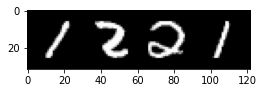

In [27]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    #첫번째 원소를 두번째, 두번째 원소를 마지막, 마지막 원소를 첫번째 위치로


# get some random training images
dataiter = iter(trainloader) #iter는 원하는 값이 나올 때 까지 특정대상을 계속 돌림
images, labels = dataiter.next() #iter 다음에는 next로 부름
print(images.shape) # 4개 짜리 미니배치, 이미지 사이즈는 (3,32,32)
print(labels) # y가 숫자로 되어있고 그 숫자를 부르는 것임. 그래서label[j]가 필요

# show images
imshow(torchvision.utils.make_grid(images, nrow = 4, padding=2,
                            normalize= False))
#Make a grid of images.
#torchvision.utils.make_grid(images)
#display(torchvision.utils.make_grid(images, nrow = 8, padding=2,
                            #normalize= True).shape) 
                           #scale_each: bool = False, pad_value: int = 0) 
#Args:
#    tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)  
#        or a list of images all of the same size.

#print(' '.join('%5s' % classes[labels[j]] for j in range(len(images))))

# Modeling

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

      

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU()
            )
            
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),#(100,16,16,32)
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU()
            )
        
      #(100,16,16,64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(), #(100,8,8,128)
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU()
            )

        self.maxpool=torch.nn.MaxPool2d(kernel_size=2,stride=2)
        # (100, 4, 4, 128)


        self.fc1=torch.nn.Linear(3* 3 * 128, 256)
        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        self.drop=torch.nn.Dropout(0.5)
        self.relu=torch.nn.ReLU()
        
        
        self.fc2=torch.nn.Linear(256, 128, bias=False)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)
        self.drop=torch.nn.Dropout(0.5)
        self.relu=torch.nn.ReLU()

        self.fc3=torch.nn.Linear(128, 1, bias=False)
        torch.nn.init.kaiming_uniform_(self.fc3.weight)
        self.drop=torch.nn.Dropout(0.5)
        
        
        self.result_layer=torch.nn.Sigmoid()
         
        # 전결합층 한정으로 가중치 초기화
        #torch.nn.init.kaiming_uniform_(self.result_layer.weight)
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.maxpool(out)
        out = out.view(-1,3*3*128)    # 전결합층을 위해서 Flatten
        out = self.fc1(out)
        out = self.drop(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.drop(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.drop(out)
        out = self.result_layer(out)
        return out

'''class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x '''


'class Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.fc1 = nn.Linear(16 * 5 * 5, 120)\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, 10)\n\n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(x)))\n        x = self.pool(F.relu(self.conv2(x)))\n        x = x.view(-1, 16 * 5 * 5)\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x '

# Training

In [ ]:
import torch.optim as optim

training_epochs=3
learning_rate=0.1
total_batch = len(trainloader)

In [ ]:
# CNN 모델 정의
model = CNN().to(device)

criterion = torch.nn.BCELoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [ ]:
print(f'총 Epochs 수 = {training_epochs}')
acc=[]
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in trainloader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X=X.to(device)
        Y=Y.to(device,dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        avg_cost += loss / total_batch
        
        y_pred = model.forward(X) # forward 연산
        correct_prediction = torch.argmax(y_pred, 1) == Y
        accuracy = correct_prediction.float().mean()

  #어차피 softmax 함수 결과값의 크기는 그전에 dot product의 크기와 비례하기 때문이다.
    acc.append(accuracy)
    print(f'[Epoch: {epoch+1}] / cost = {avg_cost} / accuracy = {accuracy}')

총 Epochs 수 = 3


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[Epoch: 1] / cost = -206.9832763671875 / accuracy = 0.0625
[Epoch: 2] / cost = -206.0037841796875 / accuracy = 0.125
[Epoch: 3] / cost = -206.59951782226562 / accuracy = 0.0


# Visualizing

In [10]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(4, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 4, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(4, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x


In [ ]:
loader = DataLoader(
    trainset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

In [ ]:
# torch.nn.ConvTranspose2d(in_channels: int, out_channels: int, kernel_size: Union[T, Tuple[T, T]],
#                        stride: Union[T, Tuple[T, T]] = 1, padding: Union[T, Tuple[T, T]] = 0, 
#                         output_padding: Union[T, Tuple[T, T]] = 0, groups: int = 1, bias: bool = True, 
#                         dilation: int = 1, padding_mode: str = 'zeros')"

In [11]:
model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [13]:
epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        #print('Epoch {}, Batch idx {}, loss {}'.format(
            #epoch, batch_idx, loss.item()))


## Plot some images

In [20]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

tensor(0) 1


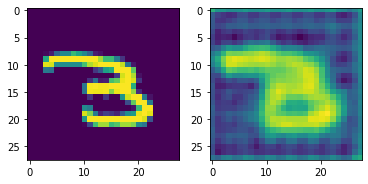

In [28]:
# Plot some images
idx = torch.randint(0, output.size(0), ())
print(idx,output.size(0))

pred = normalize_output(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())


## Visualize feature maps

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

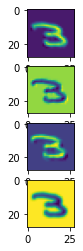

In [29]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = trainset[250]
print(data)
print("-----------------------------------------------")
data.unsqueeze_(0) #1차원 벡터로 만들어라
output = model(data)
print(output)
print("-----------------------------------------------")
act = activation['conv1'].squeeze()
print(act)

fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

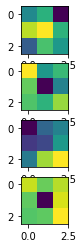

In [30]:
# Visualize conv filter
kernels = model.conv1.weight.detach()
fig, axarr = plt.subplots(kernels.size(0))
for idx in range(kernels.size(0)):
    #plt.figure(figsize=(8,8))
    axarr[idx].imshow(kernels[idx].squeeze())